In [1]:
!pip install plotly

!pip install seaborn
!pip install nltk
!pip install gensim
!pip install yellowbrick


In [2]:
#importing libraries
import pandas as pd 
import numpy as np
import nltk 
import plotly.express as px
import gensim
import gc
import string
import re
import yellowbrick
#import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots

#cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline




pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



# Glassdoor Jobs Data-Analysis 

I came up with this personal personal project to test my skills to the fullest and learn new things. In this project I scraped job postings related to the position of 'Data Scientist' from glassdoor.com,analysed the gathered data and framed a machine learning problem out of it. In the below write up I'll mention the details on what I learned. 
I selected states of California,Washington,New York as major areas to find the roles.

You can find the code for scraping and Modelling in my git link.
Github Link : https://github.com/Atharva-Phatak/Glassdoor-Jobs_Data-Analysis

## About Glassdoor

![glass](https://upload.wikimedia.org/wikipedia/commons/e/e1/Glassdoor_logo.svg)

Glassdoor is a website where current and former employees anonymously review companies. Glassdoor also allows users to anonymously submit and view salaries as well as search and apply for jobs on its platform.Glassdoor launched its site in 2008 , as a site that “collects company reviews and real salaries from employees of large companies and displays them anonymously for all members to see,” according to TechCrunch. The company then averaged the reported salaries, posting these averages alongside the reviews employees made of the management and culture of the companies they worked for—including some of the larger tech companies like Google and Yahoo. The site also allows the posting of office photographs and other company-relevant media.

## ***Information About the columns present in the Data***

1. There are 12 columns in the data they are as follows:
    * ***Job_title*** : The title of job which you are applying to
    * ***Company*** : Company name
    * ***State/City*** : State/City in which the companies job posting is listed.
    * ***Min_Salary*** : Minimum yearly salary in USD.
    * ***Max_Salary*** : Maximum yearly salary in USD.
    * ***Job_Desc*** : The job description which included skills,requirements,etc
    * ***Industry*** : The industry in which the company works.
    * ***Date_posted*** : The date  on which the job was posted on glassdoor
    * ***Valid_until*** : The last date of applying to the job.
    * ***Job_Type*** : Type of job full-time , part-time,etc.
2. All the data collected is about job lisitng for Data Scientist and related roles. The job listings are scraped from ***Glassdoor.co.in***

In [3]:
df_ny = pd.read_csv('../input/glassdoor-data-science-job-data/Data_Job_NY.csv')
df_sf = pd.read_csv('../input/glassdoor-data-science-job-data/Data_Job_SF.csv')
df_tx = pd.read_csv('../input/glassdoor-data-science-job-data/Data_Job_TX.csv')
df_wa = pd.read_csv('../input/glassdoor-data-science-job-data/Data_Job_WA.csv')
#Concatenating the data files

data_df = pd.concat([df_ny , df_sf , df_tx,df_wa] , axis = 0 , ignore_index = True)


In [4]:
del df_ny , df_sf , df_tx ,df_wa
gc.collect()

24

In [5]:
#Beginning the Cleaning and analysis of the data
#data_df.head(1)

In [6]:
#data_df.tail(1)

In [7]:
data_df.shape

(3324, 12)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3324 entries, 0 to 3323
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Job_title    3324 non-null   object 
 1   Company      3324 non-null   object 
 2   State        3322 non-null   object 
 3   City         3318 non-null   object 
 4   Min_Salary   3324 non-null   int64  
 5   Max_Salary   3324 non-null   int64  
 6   Job_Desc     3324 non-null   object 
 7   Industry     2700 non-null   object 
 8   Rating       2849 non-null   float64
 9   Date_Posted  3324 non-null   object 
 10  Valid_until  3324 non-null   object 
 11  Job_Type     3324 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 311.8+ KB


In [9]:
#First let's convert min_salary and max_salary columns to int
data_df['Min_Salary'] = data_df['Min_Salary'].apply(lambda x : int(x))
data_df['Max_Salary'] =data_df['Max_Salary'].apply(lambda x : int(x))

In [10]:
#Extracting date and day from Date_Posted : data is the format y-m-d
import calendar
data_df['Month'] = data_df['Date_Posted'].apply(lambda x : calendar.month_abbr[int(str(x).split('-')[1])]) 
#data_df['Month'] = data_df['Month'].apply(lambda x : calendar.month_abbr[int(x)])


In [11]:
def Convert_to_Day(x):
    sl = x.split('-')
    
    return calendar.day_abbr[int(calendar.weekday(int(sl[0]) , int(sl[1]) , int(sl[2])))]

data_df['Day'] = data_df['Date_Posted'].apply(lambda x : Convert_to_Day(x))

In [12]:
#While collecting the data if no salary is found I replaced the value by -1 so lets store that data in different data frame
index_missing = data_df[(data_df['Min_Salary'] == -1)].index
test_df = data_df.iloc[index_missing, :].reset_index(drop = True)
data_df.drop(index_missing , axis = 0 , inplace = True)
data_df = data_df.reset_index(drop = True)
#We will use this data as our test set.

In [13]:
#Now that we have train and test set there are duplicates in the data becasue our scraper was not perfect and could havea assimilated multiple entries
cols = [col for col in data_df.columns if col not in ['Day' , 'Month']]
#For training data 
train_series = data_df.duplicated(cols , keep = 'first')
data_df =data_df[~train_series].reset_index(drop = True)
test_series = test_df.duplicated(cols , keep = 'first')
test_df = test_df[~test_series].reset_index(drop = True)

##  Exploratory Data Analysis

* It's time to explore features of the data and get our hands dirty.



## State Column

* United States of America has 50 states but we have collected data mainly by using city search like San Fransico, New York ,etc
* Here is a map of states in USA

![map](http://ontheworldmap.com/usa/us-state-abbreviations-map-max.jpg)


In [14]:
#Unique States

print(data_df['State'].unique())

['NY' 'NJ' 'CA' 'KY' 'TX' 'TN' 'VA' 'MD' 'DC' 'NC']


In [15]:
#Let's explore the top 5 cites in which most job lisitngs are there
for state in data_df['State'].unique():
    print(f"State of {state}")
    print(data_df[data_df['State'] == state]['City'].value_counts()[:5])



State of NY
New York          8
Williston Park    1
Rego Park         1
Brooklyn          1
Staten Island     1
Name: City, dtype: int64
State of NJ
Jersey City    2
Paramus        1
Name: City, dtype: int64
State of CA
San Francisco          302
South San Francisco    122
Menlo Park              29
San Mateo               27
Redwood City            20
Name: City, dtype: int64
State of KY
Florence    1
Name: City, dtype: int64
State of TX
Austin         132
Dallas          79
Houston         67
San Antonio     40
Irving          40
Name: City, dtype: int64
State of TN
Chennai    1
Name: City, dtype: int64
State of VA
Arlington      77
McLean         50
Reston         35
Springfield    34
Chantilly      29
Name: City, dtype: int64
State of MD
Gaithersburg     41
Rockville        36
Silver Spring    25
College Park     23
Bethesda         20
Name: City, dtype: int64
State of DC
Washington    154
Name: City, dtype: int64
State of NC
Raleigh    1
Name: City, dtype: int64


* No Doubt Silicon valley Hub, San Fransico is dominating with most number of job openings

In [16]:
#Pie Chart of CA and NY

max_state = ['CA' , 'TX']
fig = make_subplots(rows = 1 , cols =2 , specs=[[{'type':'domain'}, {'type':'domain'}]])
for i,state in enumerate(max_state,1):
    cities = data_df[data_df['State'] == state]['City'].value_counts()[:5].index.to_list()
    counts = data_df[data_df["State"] == state]['City'].value_counts()[:5].to_list()
    fig.add_trace(go.Pie(labels = cities ,values = counts  ,name = state),1,i)
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="States with most number of jobs",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text= 'CA', x=0.20, y=0.5, font_size=25, showarrow=False),
                 dict(text='TX', x=0.82, y=0.5, font_size=25, showarrow=False)])
fig.show()

In [17]:
#Dropping the states where value of number of jobs will be one as they'll be outliers
index = data_df[(data_df['State'] =='NC') | (data_df['State'] =='TN') | (data_df['State'] =='KY')].index
data_df.drop(index , inplace = True)

In [18]:
#Let's the avg minimal salaries for states 
import numpy as np
states = data_df['State'].unique().tolist()
fig = go.Figure()
min_sal =  data_df.groupby('State')['Min_Salary']
max_sal =  data_df.groupby('State')['Max_Salary']
fig.add_trace(go.Bar(x = states,
                    y = min_sal.mean(),
                    name = 'Min Salary' , marker_color = 'Magenta'))

fig.add_trace(go.Bar(x = states,
                    y = max_sal.mean(),
                    name = 'Max Salary' , marker_color = 'SkyBlue'))
fig.update_layout(template = 'ggplot2', barmode = 'group')
fig.show()


## What's the Inference about salaries ?
* Minimal Average salary for NY is greater CA & DC, that can be because of the less data points for NY state indicating it is an outlier.
* Both DC and California offer almost the same average salaries both minimal and maximal.

In [19]:
#Let's see avg minimal salaries according to top  5 cities 
states = ["CA",'TX','DC']
fig = make_subplots(rows = 3 , cols = 1,specs = [[{"type": "xy"}],[{"type": "xy"}],[{"type": "xy"}]])
colors = ['#2e9dd4' ,'#e76969' ,'#4fd882' ,'#f22dea' , '#e7468f']
for i,state in enumerate(states,1):

    cities = data_df[data_df['State'] == state]['City'].value_counts()[:5].index.to_list()
    avg_min_sals = []
    for city in cities:
        

        avg_min_sals.append(int(data_df[data_df['City'] == city]['Min_Salary'].mean()))
    fig.add_trace(go.Bar(x = cities , y = avg_min_sals  ,marker_color = colors ,name = state),i,1)
fig.update_layout(template = 'ggplot2' , title = "Average Minimal Salaries per city in states with most number of Jobs")
fig.show()




* The city with the highest avg minimal salary is South San Fransico.

In [20]:
#Job Types in States with Max number of Jobs
for state in states:
    print(f"Type of Jobs in state of {state}")
    print(data_df[data_df['State'] == state]['Job_Type'].value_counts())

Type of Jobs in state of CA
FULL_TIME     616
PART_TIME       8
OTHER           4
CONTRACTOR      4
Name: Job_Type, dtype: int64
Type of Jobs in state of TX
FULL_TIME     453
OTHER           7
PART_TIME       6
CONTRACTOR      2
TEMPORARY       1
Name: Job_Type, dtype: int64
Type of Jobs in state of DC
FULL_TIME    146
PART_TIME      7
OTHER          1
Name: Job_Type, dtype: int64


In [21]:
#Let's see the day on which most number of jobs are posted
day_fig = go.Figure([go.Bar(x = data_df['Day'].value_counts().index.to_list() ,
                    y = data_df['Day'].value_counts().to_list() , marker_color = 'skyblue')])
day_fig.update_layout(template = 'ggplot2' , title = 'Days with max number of jobs')

* Apparently Friday is the day in which max number of jobs were posted.

## Exploring Industries

* Data science,Machine Learning,Deep Learning is being used in varied fields from natural science all the way to finance and banking sectors.
* Naturally, our collected data will contain some of the industries but may not contain all of them.

In [22]:
#Now's  let's explore the industry column
#This column has Nan Values

ind = data_df[~data_df['Industry'].isnull()]
print(f"Number of Unique Industries : {ind.Industry.nunique()}")

Number of Unique Industries : 23


In [23]:
ind.Industry.value_counts()

Information Technology                476
Business Services                     309
Biotech & Pharmaceuticals             259
Aerospace & Defense                   126
Finance                                94
Health Care                            78
Government                             78
Education                              53
Manufacturing                          34
Media                                  27
Retail                                 26
Accounting & Legal                     25
Insurance                              25
Oil, Gas, Energy & Utilities           24
Transportation & Logistics              8
Construction, Repair & Maintenance      6
Non-Profit                              6
Telecommunications                      5
Real Estate                             4
Consumer Services                       4
Restaurants, Bars & Food Services       3
Arts, Entertainment & Recreation        2
Agriculture & Forestry                  1
Name: Industry, dtype: int64

In [24]:
#top 8 industries with max number of jobs

fig = go.Figure()
fig.add_traces(go.Pie(values = ind.Industry.value_counts()[:8].to_list(),
                    labels= ind.Industry.value_counts()[:8].index.to_list(),
                    name = 'Industry',textposition = 'inside' , textinfo = 'percent+label'))
fig.update_layout(template = 'plotly_white',title = 'Industries with most number of Data Science Related jobs' )
fig.show()

* As expected industries which come under IT sector have max number of jobs followed by industries which come under Business services.
* Though one intersting for me was Biotech requires more amount data science related individual than finance atleast for this data set.

In [25]:
#Let's see which industries dominate the states 
for state in ind.State.unique():
    print(f"State of {state}")
    print(ind[ind['State'] == state]['Industry'].value_counts()[:8])




State of NY
Finance                               3
Construction, Repair & Maintenance    2
Health Care                           2
Information Technology                1
Telecommunications                    1
Retail                                1
Biotech & Pharmaceuticals             1
Name: Industry, dtype: int64
State of NJ
Health Care    3
Name: Industry, dtype: int64
State of CA
Information Technology       205
Biotech & Pharmaceuticals    176
Business Services             30
Finance                       27
Health Care                   24
Manufacturing                 21
Retail                        17
Government                    13
Name: Industry, dtype: int64
State of TX
Information Technology          141
Business Services                76
Health Care                      44
Finance                          43
Education                        31
Government                       17
Oil, Gas, Energy & Utilities     16
Insurance                        15
Name: Industry, 

* State of DC is dominated by Business Service and the state of Maryland by Biotech industry atleast for this collected data.

In [26]:
#Lets take a look at minimal average salary for the top 8 industries
fig = go.Figure()
fig.add_trace(go.Bar(x = ind.groupby("Industry")['Min_Salary'].mean().to_list(),
y = ind.groupby("Industry")['Min_Salary'].mean().index.to_list(), marker_color = 'goldenrod',
orientation = 'h' , name = "Min Avg Salary"
))
fig.add_trace(go.Bar(x = ind.groupby("Industry")['Max_Salary'].mean().to_list(),
y = ind.groupby("Industry")['Max_Salary'].mean().index.to_list(), marker_color = 'deepskyblue'
,orientation = 'h' ,name = "Max Avg Salary"))
fig.update_layout( template = 'plotly_dark',
    title = 'Minimal And Maximal Average Annual Salaries according to industries' ,barmode = 'group')
fig.show()

* Agriculture and Forestry is an outlier if because in whole of the data there is only one example of it.
* IT industry pays the best avg minimal and maximal yearly salary.

In [27]:
#Now let's explore companies 

print(f"Number of Unique Company Names : {data_df['Company'].nunique()}")


Number of Unique Company Names : 959


In [28]:
# Companies which have most number of job postings

fig = go.Figure()
fig.add_trace(go.Bar(y = data_df['Company'].value_counts()[:20].to_list(),
x= data_df['Company'].value_counts()[:20].index.to_list(),
marker_color = 'deepskyblue' , name = "Company"))
fig.update_layout(title= 'Companies with Max Number of Job Postings related to data science',
                template = 'plotly_dark')
fig.show()

* According to our data and the above plot **Genentech**,**Booz Allen Hamilton Inc.**,**Amazon** are the companies with the most number of openings.

In [29]:
#Let's take a look at Avg Minimal and Maximal salaries for companies 
def Plot_Company_salaries(companies,title):
    fig = go.Figure()
    min_sal = []
    max_sal = []
    for company in companies:
        min_sal.append(data_df[data_df['Company'] == company]['Min_Salary'].mean())
        max_sal.append(data_df[data_df['Company'] == company]['Max_Salary'].mean())



    fig.add_trace(go.Bar(x = min_sal ,y = companies , marker_color = 'deepskyblue' 
    , name  = 'Minimal Salary' , orientation = 'h'))
    fig.add_trace(go.Bar( x= max_sal,y = companies , marker_color = 'red' , 
    name = 'Maximal Salary', orientation = 'h'))

    fig.update_layout(title = title,
    barmode = 'group' , template = 'plotly_dark')
    fig.show()
    
    

In [30]:
#Top 5 companies in CA
states = ['CA' ,'TX' ,'DC' ,'MD' ,'VA']
companies = []
titles = []
for state in states:
    companies.append(data_df[data_df['State'] == state]['Company'].value_counts()[:5].index.to_list())
    titles.append(f'{state} : Minimal And Maximal Annual Average Salaries for top 5 companies')

for i in range(len(states)):
    Plot_Company_salaries(companies[i] , titles[i])


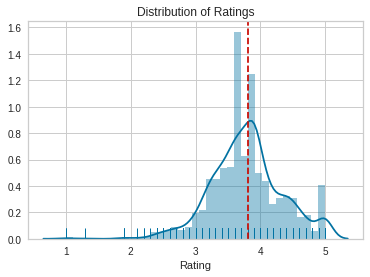

In [31]:
#Distribution of ratings of companies

ratings =data_df[~data_df['Rating'].isnull()]['Rating']
sns.distplot(ratings,kde = True , rug = True)
plt.axvline(np.median(ratings),color='r', linestyle='--')
plt.grid(True)
plt.title("Distribution of Ratings")
plt.show()

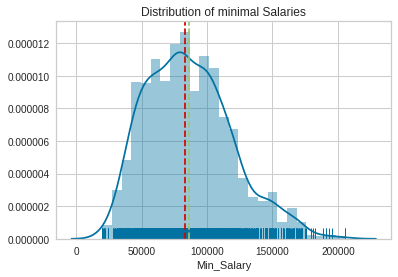

In [32]:
#Minimal Salaries distribution
sns.distplot(data_df['Min_Salary'] , kde = True , rug = True)
plt.axvline(np.median(data_df['Min_Salary']),color='r', linestyle='--')
plt.axvline(np.mean(data_df['Min_Salary']),color='g', linestyle='--')
plt.grid(True)
plt.title("Distribution of minimal Salaries")
plt.show()



In [33]:
#Box plot for minimal salaries
fig = px.box(data_df , y = 'Min_Salary' ,points = 'all')
fig.show()

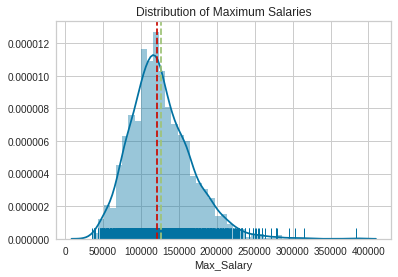

In [34]:
#Maximal Salaries distribution
sns.distplot(data_df['Max_Salary'] , kde = True , rug = True)
plt.axvline(np.median(data_df['Max_Salary']),color='r', linestyle='--')
plt.axvline(np.mean(data_df['Max_Salary']),color='g', linestyle='--')
plt.grid(True)
#plt.figure(figsize=(100,100))
plt.title("Distribution of Maximum Salaries")
plt.show()

In [35]:
#Box plot for maximal salaries
fig = px.box(data_df , y = 'Max_Salary' ,points = 'all')
fig.show()

In [36]:
#unique Job titles
data_df['Job_title'].nunique()

1252

In [37]:
#Top 8 job titles with max jobs
fig = go.Figure()
fig.add_traces(go.Pie(values = data_df.Job_title.value_counts()[:8].to_list(),
                    labels= data_df.Job_title.value_counts()[:8].index.to_list(),
                    name = 'Job Title',textposition = 'inside' , textinfo = 'percent+label'))
fig.update_layout(template = 'plotly_white',title = 'Job Titles with most number of  jobs',
                showlegend = False )
fig.show()


In [38]:
titles = ['Data Scientist' ,'Data Analyst' ,'Data Engineer']
min_sal = []
max_sal = []
for title in titles:
    min_sal.append(data_df[data_df['Job_title'] == title]['Min_Salary'].mean())
    max_sal.append(data_df[data_df['Job_title'] == title]['Max_Salary'].mean())

fig = go.Figure()
fig.add_trace(go.Bar(x = min_sal ,y = titles , marker_color = 'deepskyblue',
orientation = 'h' , name = 'Min Salary'))
fig.add_trace(go.Bar(x = max_sal ,y = titles , marker_color = 'magenta',
orientation = 'h' , name = 'Max Salary'))
fig.update_layout(title = 'Annual Avergae Salaries for Job titles having most jobs',
barmode = 'group' ,template = 'plotly_white')
fig.show()

## Extracting Features out of Job Description 

In [39]:
#Let's See how the description actually looks
x = data_df.Job_Desc[0].replace('\n\n' , '\n')
x = x.split('\n')

print(*x , sep = '\n')

Principle Duties & Responsibilities:
Analyze complex systems and troubleshoot and isolate system issues;
Understand requirements for business users and translate into design specifications, utilizing thorough understanding of the Salesforce platform, Salesforce products and licensing models;
Utilize thorough understanding of application development, project lifecycle, and methodologies and ability to work under tight deadlines and handle multiple detail-oriented tasks;
Apply knowledge of Salesforce developmentand customizations, with APEX, Visual Force, API, Force.com and Workflows, taking into account com best practices, support mechanisms, procedures, and limitations, as well as NDR's unique needs;
Responsible for Salesforce administration, release management and deployment as well as management of Salesforce.com sandboxes, including their integrations;
Design and execute Salesforce.com configuration changes, leveraging the Salesforce interface to sync with internal tracking systems;

## Some Observation on Job Description

Here's what I observe 
* There are '\n' which need to removed
* The descriprion is mostly structred as follows though the order of it can be different

    * Info About Company
    * Qualifications
    * Duties
    * Requirements


In [40]:
#Let's clean \n
data_df['Job_Desc'] = data_df['Job_Desc'].replace('\n\n' , " " , regex = True)
data_df['Job_Desc'] = data_df['Job_Desc'].replace('\n' , " " , regex = True)

test_df['Job_Desc'] = test_df['Job_Desc'].replace('\n\n' , " " , regex = True)
test_df['Job_Desc'] = test_df['Job_Desc'].replace('\n' , " " , regex = True)
#Let's remove punctuation and Stopwords

from gensim.parsing.preprocessing import remove_stopwords
def Remove_puncutations_stopwords(s):

    s = ''.join([i for i in s if i not in string.punctuation])
    s = remove_stopwords(s)
    return s

data_df['Job_Desc'] = data_df['Job_Desc'].apply(lambda x : Remove_puncutations_stopwords(x))

test_df['Job_Desc'] = test_df['Job_Desc'].apply(lambda x : Remove_puncutations_stopwords(x))

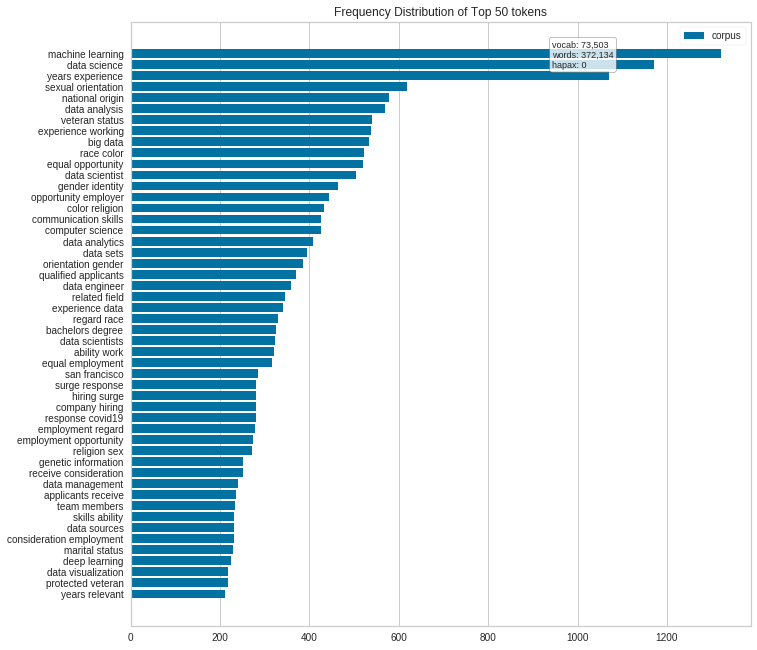

In [41]:
#Let's try to visualize counts of the tokens
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

vec = CountVectorizer(min_df= 2 , stop_words = 'english' , ngram_range = (2,2))
docs = vec.fit_transform(data_df.Job_Desc)
features = vec.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='h' , size = (800,800))
visualizer.fit(docs)
visualizer.show()

* As you can see count vecotrizer mentions the most repeating bi-grams in the Job_Desc. We can create features out it.

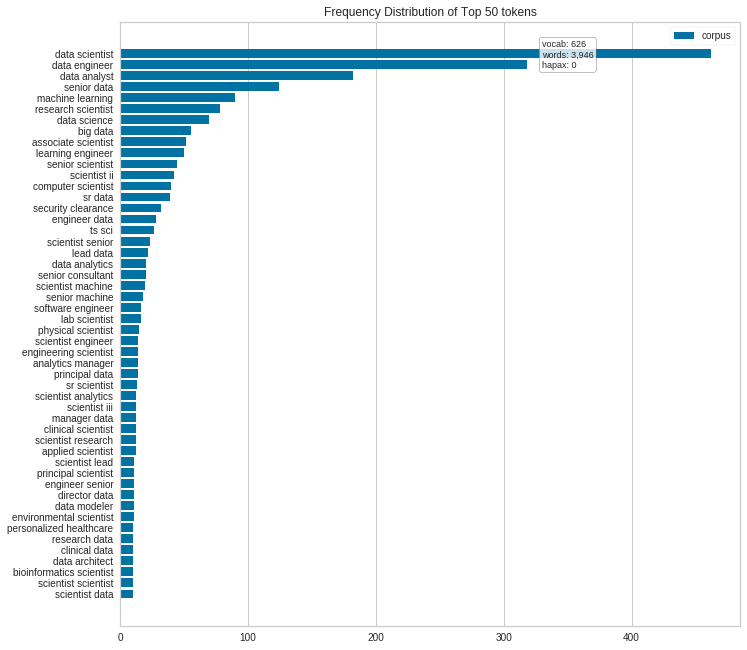

In [42]:
#Let's test it out for job_titles

vec_title = CountVectorizer(min_df= 2 , stop_words = 'english' , ngram_range = (2,2))
docs_titles = vec.fit_transform(data_df.Job_title)
features_title = vec.get_feature_names()

visualizer = FreqDistVisualizer(features=features_title, orient='h' , size = (800,800))
visualizer.fit(docs_titles)
visualizer.show()

In [43]:
#Now let's take average of minimal and maximal salary find its median

data_df['avg_sal'] = (data_df['Min_Salary'] + data_df['Max_Salary'])//2


In [44]:
#Median avg annual salary
print(f"Median average annual salary is {data_df['avg_sal'].median()}")
median_sal = data_df['avg_sal'].median()
data_df['is_higher'] = [1 if i > median_sal else 0 for i in data_df.avg_sal]
data_df.to_csv("train_data.csv" , index = False)
test_df.to_csv('test_data.csv' , index = False)

Median average annual salary is 102378.5
